In [0]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(15,15)})


Suggestion: try PLA on this dataset before using the bank dataset

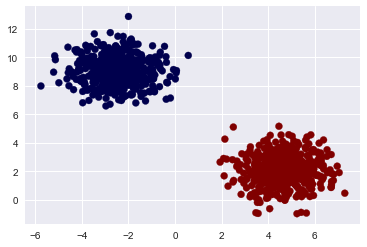

In [7]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=42)
y = [yy if yy == 1 else -1 for yy in y] 
plt.scatter(X[:,0],X[:,1], c=y, cmap='seismic')

In [8]:
def h(x,w):
    #Perceptron model: the sign of the dot product of weights and input vector determines the class allocation
    bias = np.array([1])
    return np.sign(w.T.dot(np.concatenate((bias,x))))

In [9]:
def point_on_boundary(weights, x):
    # Return the y-position on the boundary based on given x-position
    return -(weights[0]+weights[1]*x)/weights[2]

In [10]:
def decision_boundary(weights, x_min, x_max):
    # Return two points on the decision boundary
    return [point_on_boundary(weights, x_min), point_on_boundary(weights, x_max)]

In [11]:
def pla(training_in, training_out, weights):
    bias = np.array([1])
    iterations=0
    while True:
        errors = 0;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                iterations+=1;
                weights = weights + y*(np.concatenate((bias,x)))
                errors+=1;
        if (errors == 0):
            break
    return weights, iterations

In [12]:
def calc_error(training_in, training_out, weights):
    # Calculate the classification error as the fraction of training samples that are misclassified
    errors=0
    for x,y in zip(training_in, training_out):
        if (h(x,weights)!=y):
            errors+=1;
    return errors/len(training_in)

In [13]:
def plot_graph(training_in, training_out, weights):
    plt.scatter(training_in[:,0],training_in[:,1], c=training_out, cmap='seismic')
    x_min = min(training_in[:,0])
    x_max = max(training_in[:,0])
    y_min, y_max = decision_boundary(weights, x_min, x_max)

    plt.plot([x_min, x_max], [y_min, y_max])
    plt.show()

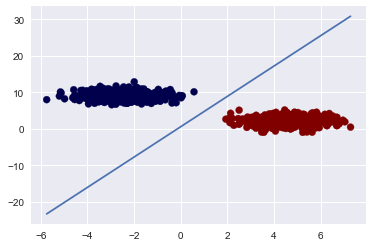

In [14]:
weights, iterations = pla(X, y, np.ones(3))
plot_graph(X, y, weights)

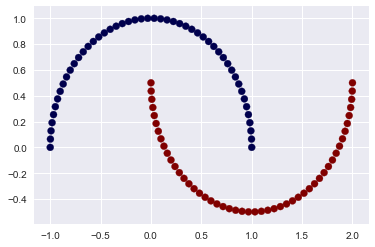

In [15]:
X, y = make_moons()
y = [yy if yy == 1 else -1 for yy in y] 
plt.scatter(X[:,0],X[:,1], c=y, cmap='seismic')

In [16]:
def pla_with_pocket(training_in, training_out, weights, max_iterations=5):
    bias = np.array([1])
    iterations = 0
    best_error = 1
    while iterations < max_iterations:
        errors = 0;
        sample = 0
        for x,y in zip(training_in, training_out):
            sample += 1
            if sample % 100 == 0:
              print(sample)
            if (h(x,weights)!=y):
                weights = weights + y*(np.concatenate((bias,x)))

                error = calc_error(training_in, training_out, weights)
                if error < best_error:
                    best_error = error
                    best_weights = weights
                    print("new best error: " + str(best_error))
            
            iterations += 1
    return best_weights, best_error

In [17]:
weights, iterations = pla_with_pocket(X,y,np.random.uniform(-1,1,3))
print(weights)
print(iterations)
calc_error(X, y, weights)

new best error: 0.43
new best error: 0.2
new best error: 0.16
new best error: 0.15
new best error: 0.14
new best error: 0.12
100
[ 0.39759152  0.44945006 -2.78994452]
0.12


0.12

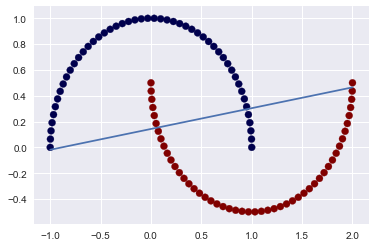

In [18]:
plot_graph(X, y, weights)

In [4]:
# from google.colab import files
# import io

# uploaded = files.upload()

# dataset = pd.read_csv(io.BytesIO(uploaded['bank_et1.csv']))
# Dataset is now stored in a Pandas Dataframe

dataset = pd.read_csv("bank_et1.csv", index_col=0)

In [5]:
dataset.head()

,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,32,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,39,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,59,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,47,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,54,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [125]:
dataset.tail()

,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,20,student,single,NaN,no,2785,-2.170524,1.081071,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,28,admin.,single,secondary,no,127,0.811788,1.134496,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,81,retired,married,primary,no,1154,0.504655,0.042190,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,46,services,married,primary,no,4343,-0.965874,0.302708,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,40,entrepreneur,married,secondary,no,6403,-0.800893,1.066659,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


From this brief look can see that potentially `default`,`housing`,`loan`,`subscribed` would seem to be likely candidates as dependent variables as they seem to have binary looking descriptors ('yes' or 'no') and do not have missing values (NaN)

We will now confirm that all the above variables have 2 possible values and no missing values.

In [126]:
print(dataset['default'].value_counts())
print(dataset['housing'].value_counts())
print(dataset['loan'].value_counts())
print(dataset['subscribed'].value_counts())

no     1985
yes      15
Name: default, dtype: int64
no     1037
yes     963
Name: housing, dtype: int64
no     1750
yes     250
Name: loan, dtype: int64
yes    1000
no     1000
Name: subscribed, dtype: int64


As we can see all the above are indeed binary choices, I will choose `subscribed` as it is balanced (Has an equal number of instances of each category)

### Numerical & Categorical Statistics

In [127]:
dataset.describe(include='all')

,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
count,2000.000000,1990,2000,1896,2000,2000.000000,2000.000000,2000.000000,2000,2000,1809,2000.000000,2000,2000.000000,2000.000000,2000.000000,2000.000000,1546,2000
unique,NaN,11,3,3,2,NaN,NaN,NaN,2,2,2,NaN,12,NaN,NaN,NaN,NaN,3,2
top,NaN,management,married,secondary,no,NaN,NaN,NaN,no,no,cellular,NaN,feb,NaN,NaN,NaN,NaN,failure,yes
freq,NaN,461,1111,995,1985,NaN,NaN,NaN,1037,1750,1663,NaN,404,NaN,NaN,NaN,NaN,955,1000
mean,41.751500,NaN,NaN,NaN,NaN,1413.663500,0.241951,0.485030,NaN,NaN,NaN,13.851500,NaN,292.020500,1.909500,167.896000,2.561500,NaN,NaN
std,12.723077,NaN,NaN,NaN,NaN,3131.224213,0.821604,1.075543,NaN,NaN,NaN,9.712189,NaN,221.557295,1.378862,131.754126,3.400735,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-980.000000,-2.632068,-2.851405,NaN,NaN,NaN,1.000000,NaN,7.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,32.000000,NaN,NaN,NaN,NaN,201.500000,-0.308018,-0.274181,NaN,NaN,NaN,5.000000,NaN,146.000000,1.000000,75.750000,1.000000,NaN,NaN
50%,38.000000,NaN,NaN,NaN,NaN,551.000000,0.224099,0.487082,NaN,NaN,NaN,12.000000,NaN,236.000000,1.000000,182.000000,2.000000,NaN,NaN
75%,50.000000,NaN,NaN,NaN,NaN,1644.500000,0.806315,1.211896,NaN,NaN,NaN,23.000000,NaN,379.000000,2.000000,251.000000,3.000000,NaN,NaN


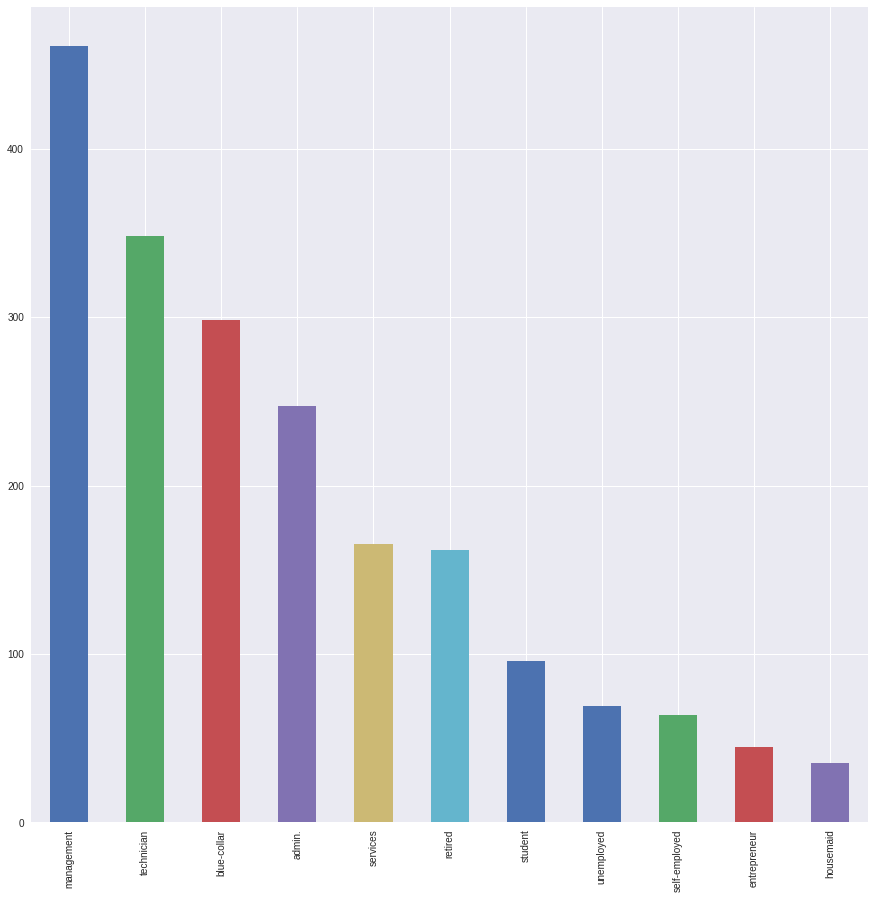

In [128]:
dataset['job'].value_counts().plot(kind='bar')

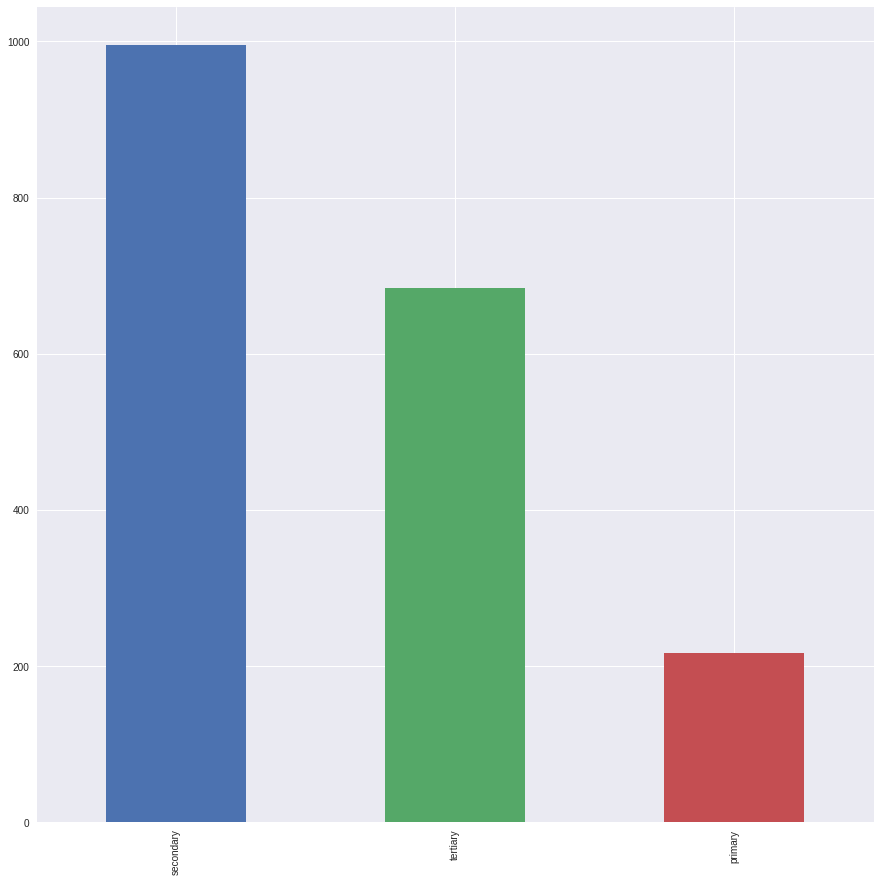

In [129]:
dataset['education'].value_counts().plot(kind='bar')

(array([ 91., 429., 595., 294., 268., 190.,  71.,  38.,  20.,   4.]),
 array([18. , 25.5, 33. , 40.5, 48. , 55.5, 63. , 70.5, 78. , 85.5, 93. ]),
 <a list of 10 Patch objects>)

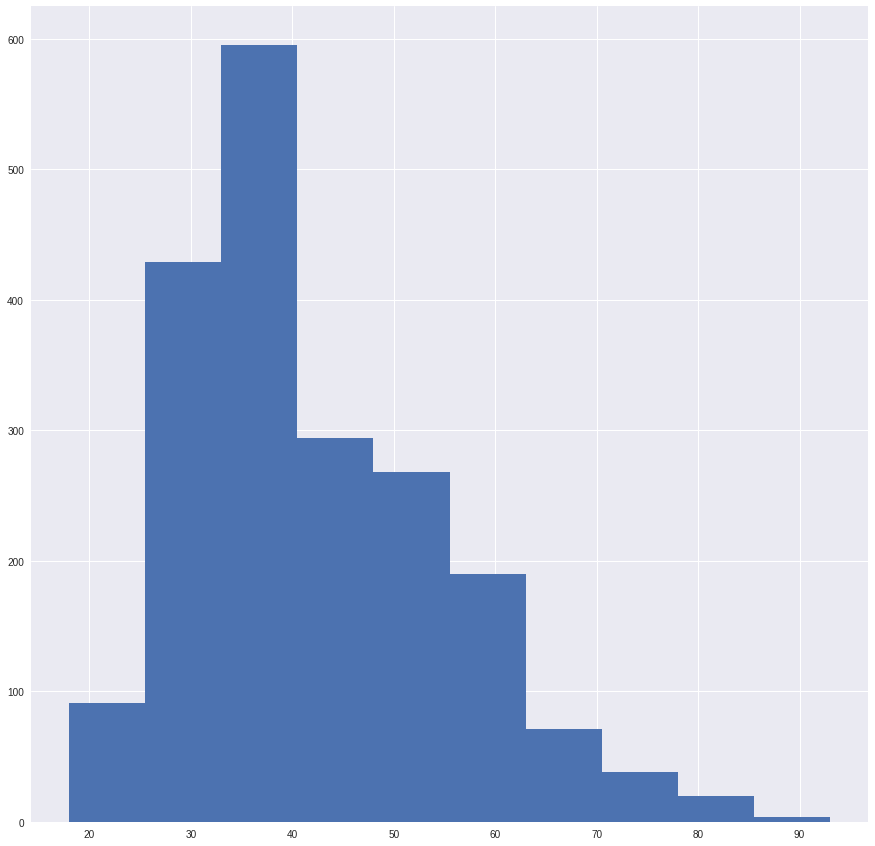

In [130]:
plt.hist(dataset['age'])

(array([127., 289., 305., 341., 255., 174., 140., 104.,  59.,  48.,  40.,
         28.,  14.,  15.,  15.,   7.,   7.,   6.,   7.,   6.,   3.,   1.,
          2.,   3.,   1.,   1.,   0.,   0.,   1.,   1.]),
 array([   7.        ,   67.53333333,  128.06666667,  188.6       ,
         249.13333333,  309.66666667,  370.2       ,  430.73333333,
         491.26666667,  551.8       ,  612.33333333,  672.86666667,
         733.4       ,  793.93333333,  854.46666667,  915.        ,
         975.53333333, 1036.06666667, 1096.6       , 1157.13333333,
        1217.66666667, 1278.2       , 1338.73333333, 1399.26666667,
        1459.8       , 1520.33333333, 1580.86666667, 1641.4       ,
        1701.93333333, 1762.46666667, 1823.        ]),
 <a list of 30 Patch objects>)

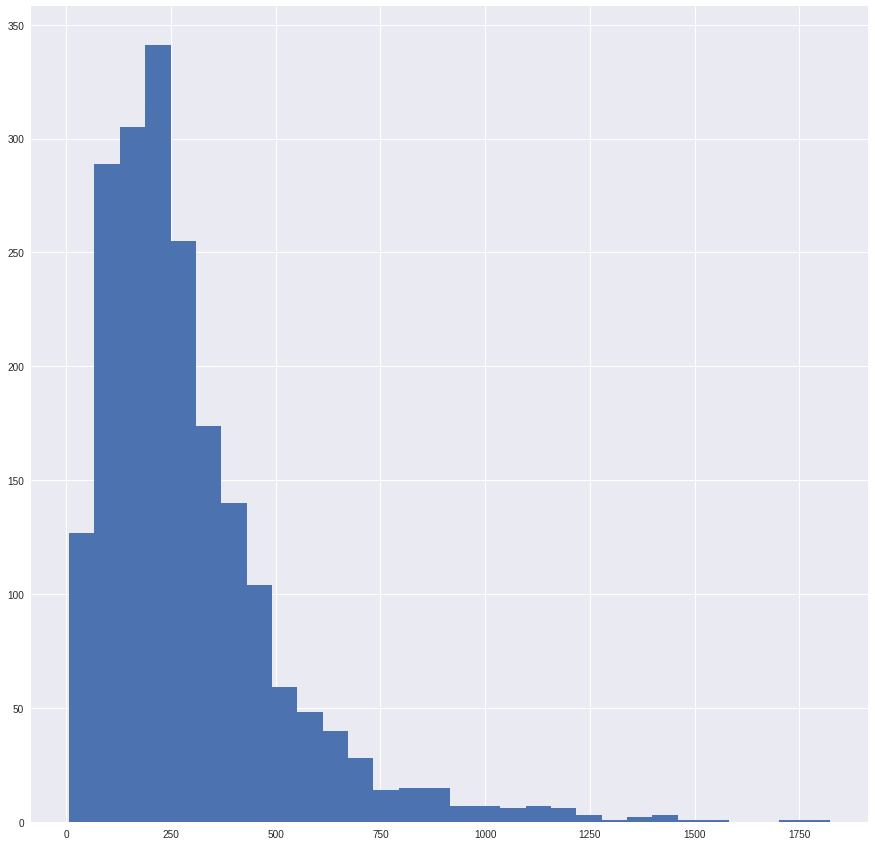

In [131]:
plt.hist(dataset['duration'], bins=30)

### Analysis of attribute distributions

Distribution for the job category shows that the largest group is 'management' (representing roughly ~23% of samples) and the smallest group is 'housemaid' (representing only 1.75% of samples)

Distribution for the education category shows that the majority of samples have secondary school as their highest level of educational acheivement (52.47% of samples) and the smallest group have primary school as their highest level of educational acheivement (11.45% of samples) while the remainder have tertiary education as their highest level of education acheivement (36.1% of samples)

Distribution of the age category is unimodal with a postive skew (more samples towards the left of the histogram) with a mean of ~41.75 and a median value of 38. Although some of the older respondants may be outliers we should not discount them as none of the ages are unrealistic (100+)

Distribution of the duration category is similar to the age distribution in that it is unimodal and is postively skewed. 

### Combined distribution of attributes

Next I will examine the distribution of income and marital status

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


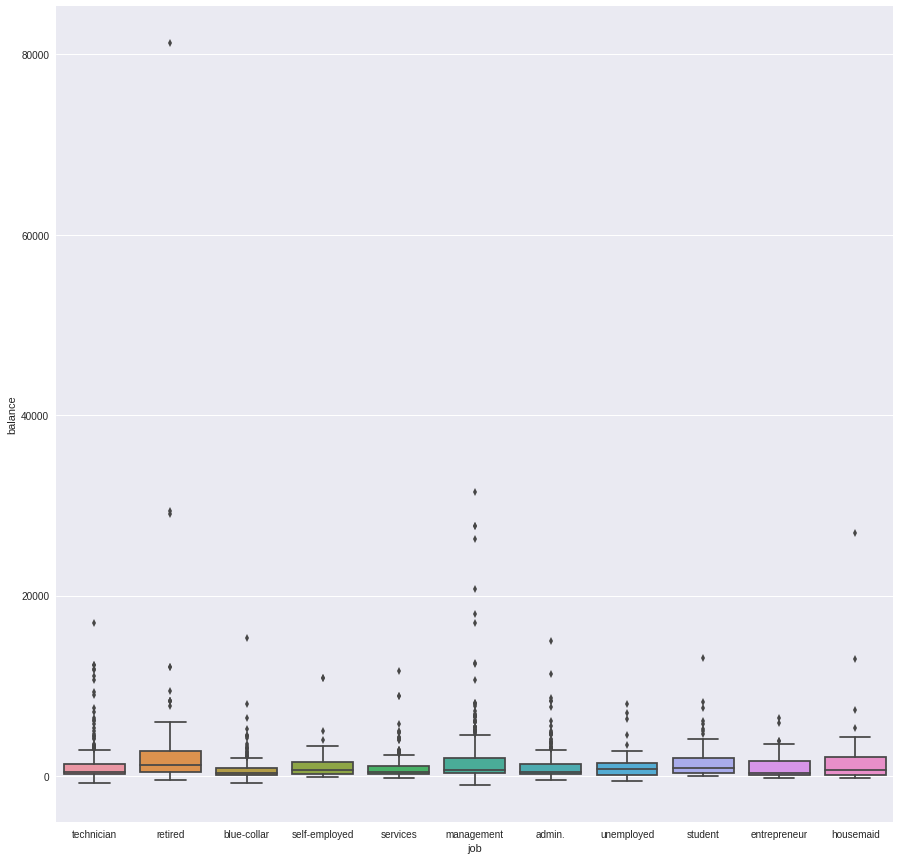

In [132]:
sns.boxplot(x="job", y="balance", data=dataset)

We can see from the provided violin plot that the retired have the widest distribution of balances including an extreme outlier which is well within the realm of credulity (~80,000) and that bluecollar workers have the smallest distribution of wages. 

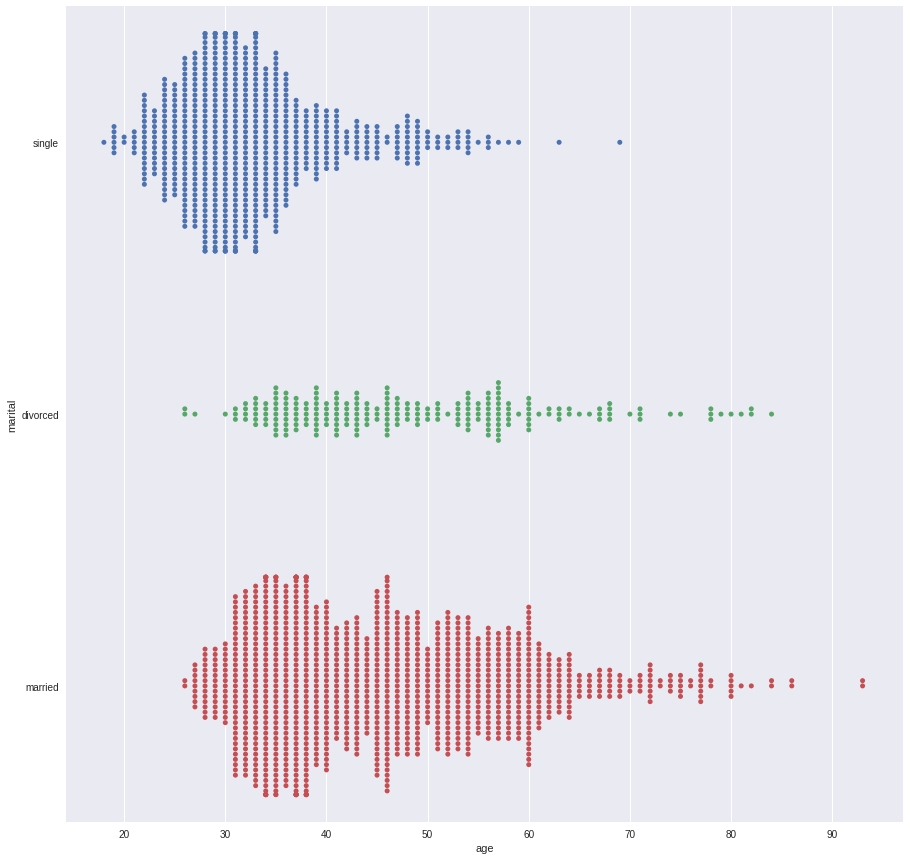

In [133]:
sns.swarmplot(x="age", y="marital", data=dataset)

We can see from the above swarm plot that the age distribution of single people is skewed more positively than both  and the married divorced.

Divorced people appear to be more bimodally distributed with a larger number of people in their mid 30s and 50s getting divorced than at other ages. The larger number in the mid 30s getting divorced is probably due to a larger overall number of married people in this age pool.

## Numerical Attributes which could predict our Dependenet variable

I will now generate plots to identify which numerical variables might be a good predictor for our dependant variable "subscription" 

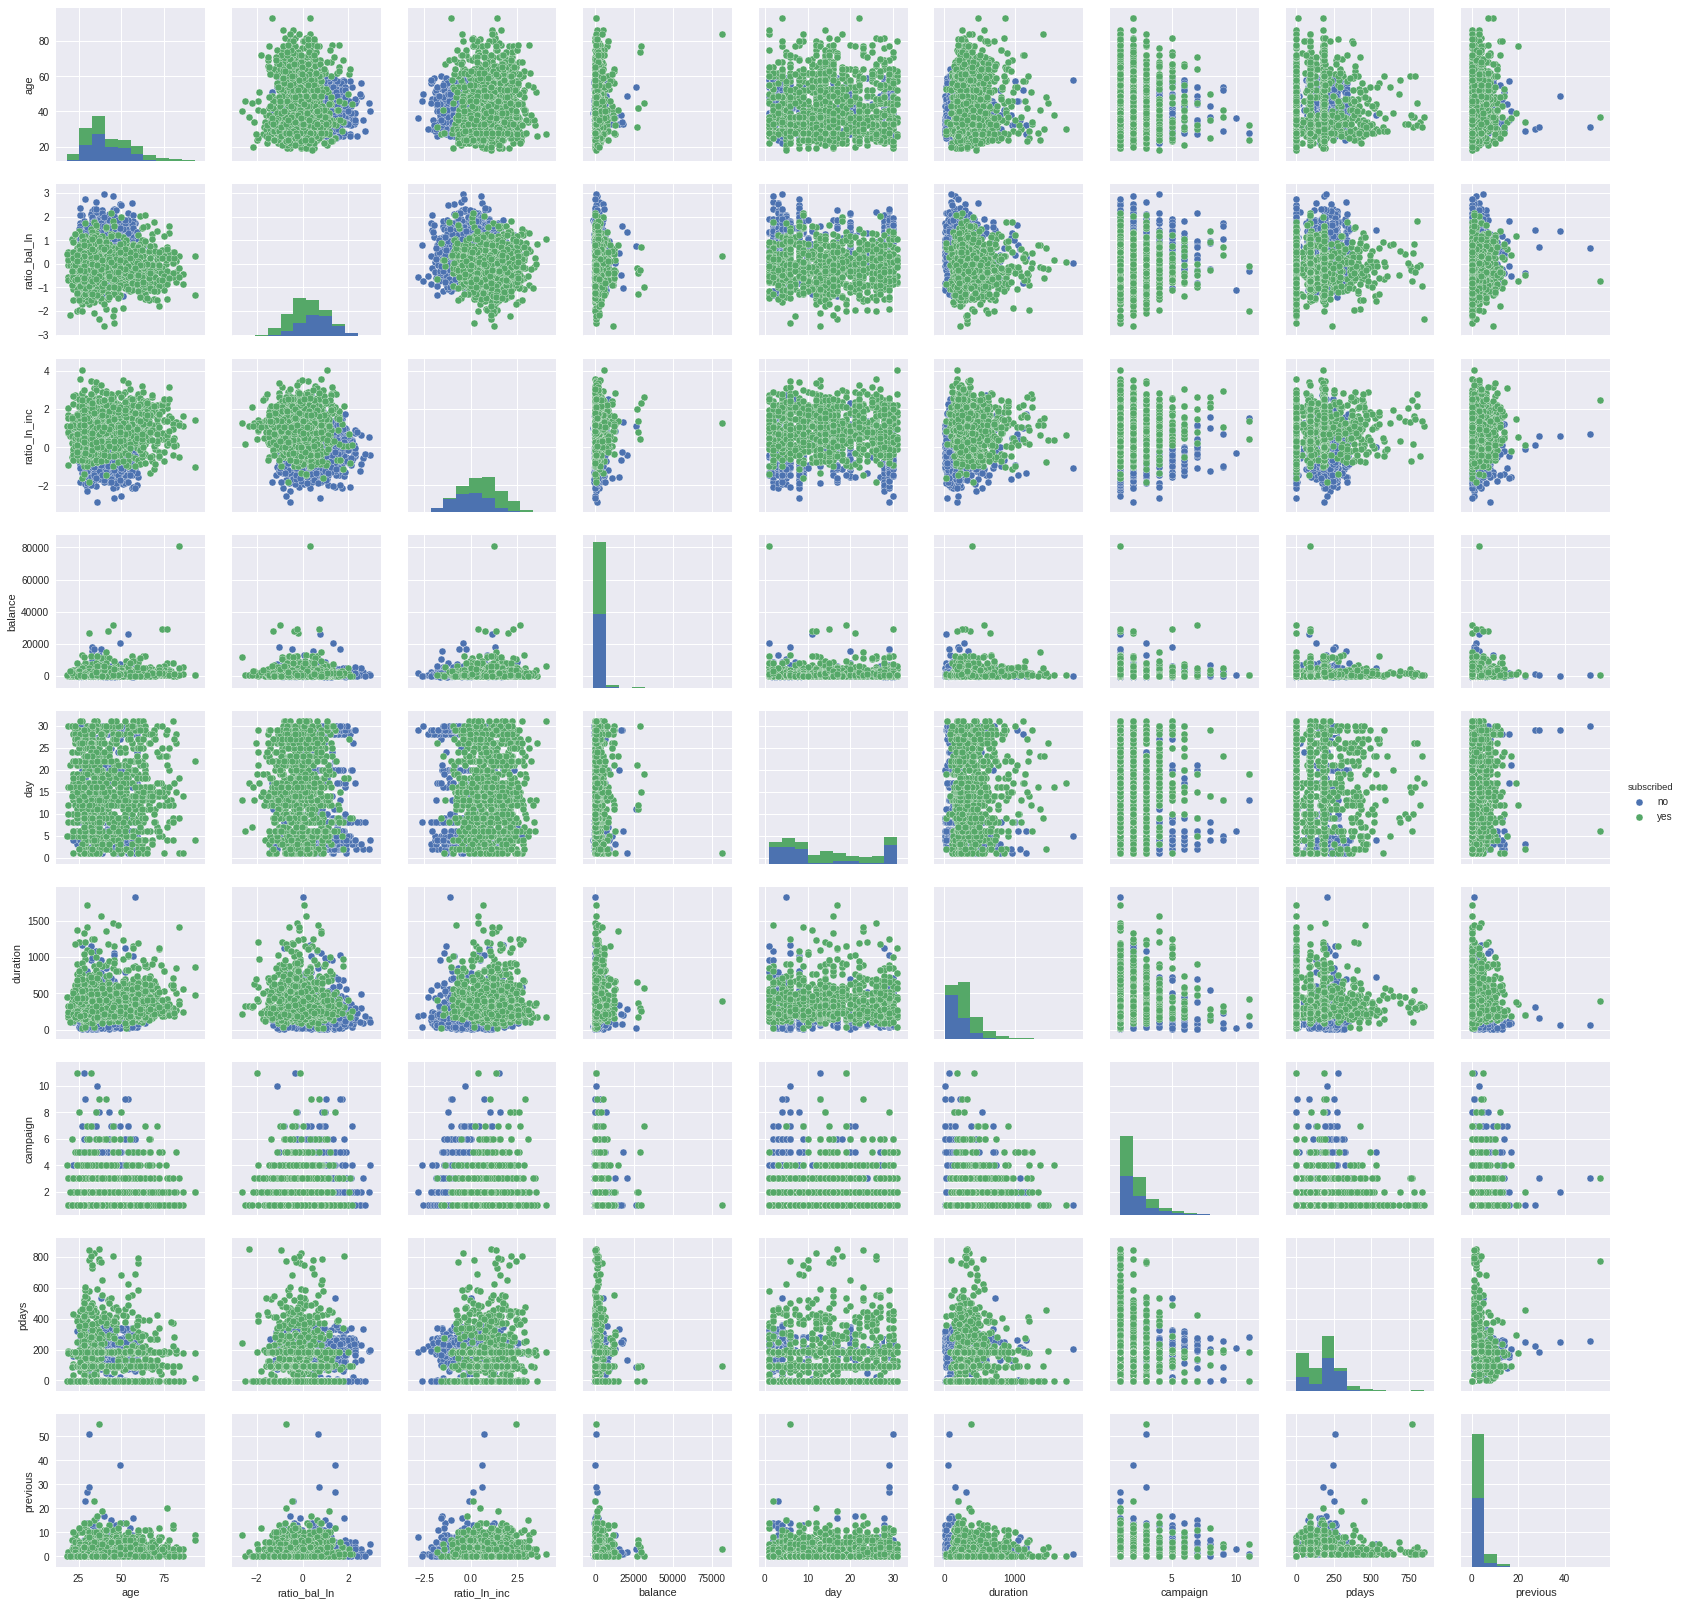

In [134]:
sns.pairplot(dataset, hue = 'subscribed', vars=["age", "ratio_bal_ln", "ratio_ln_inc", "balance", "day", "duration","campaign","pdays","previous"])

We can see from the above pair plots that ratio_bal_in and ratio_in_inc would appear to be the two most linearly seperable numerical pairs. Though there is a lot of overlap so we would expect an unalter PLA algorithm to fail.

### Classification Description

The dataset for our classification problem is a bank record of customers who they have tried to get to subscribe to an additional product.

The input space for the problem is the total set of all possible attributes in the dataset except for our subscribed field. The output space is the possible values of our dependent variable subscribed.

We will  be using a learning algorithm to select from a pool of hypothesis set a final hypothesis function which we hope approximates the target function (or optimum solution). We will measure the in sample error of the resulting output of our final hypothesis and although we are unable to measure the out of sample error (i.e. it's ability to generalise to new data) we can make use of the Hoeffding Inequality so we know that the difference between our in sample error and our out of sample error is bounded.

For this implementation I will be reducing the input space to just our previously defined numerical points 'ratio_bal_in' and 'ratio_in_inc' as the learning algorithm which we are using to extract the final hypothesis from: "PLA" is best suited for data which is linearly seperable and as stated before these look to be the most linearly seperable.

As there is a large amount of clustering we will be using the pocket algorithm to improve our base PLA algorithm.






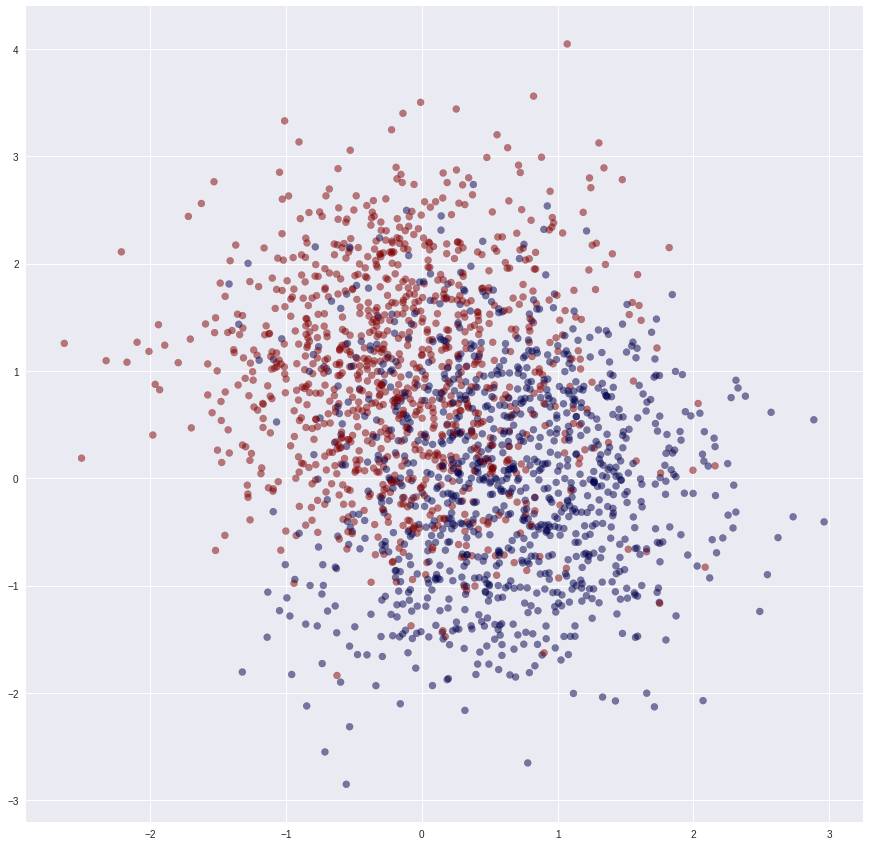

In [135]:
shuffled_dataset = dataset.sample(frac=1).reset_index(drop=True)
X = pd.concat([shuffled_dataset['ratio_bal_ln'], shuffled_dataset['ratio_ln_inc']], axis=1).values
y = shuffled_dataset['subscribed'].map(dict(yes=1, no=-1)).values

plt.scatter(X[:,0],X[:,1], c=y, cmap='seismic', alpha=.5)

In [137]:
##randomise initial weights
initial_weights = np.random.uniform(-1,1,3)
print(initial_weights)
weights, iterations = pla_with_pocket(X,y,initial_weights, 10)
calc_error(X, y, weights)
initial_weights

[ 0.98873821 -0.0669074  -0.11621001]
new best error: 0.4885
new best error: 0.4625
new best error: 0.252
new best error: 0.2195
new best error: 0.2165
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
new best error: 0.216
1700
1800
1900
2000


array([ 0.98873821, -0.0669074 , -0.11621001])

[-0.01126179 -1.22840811  1.05864799]


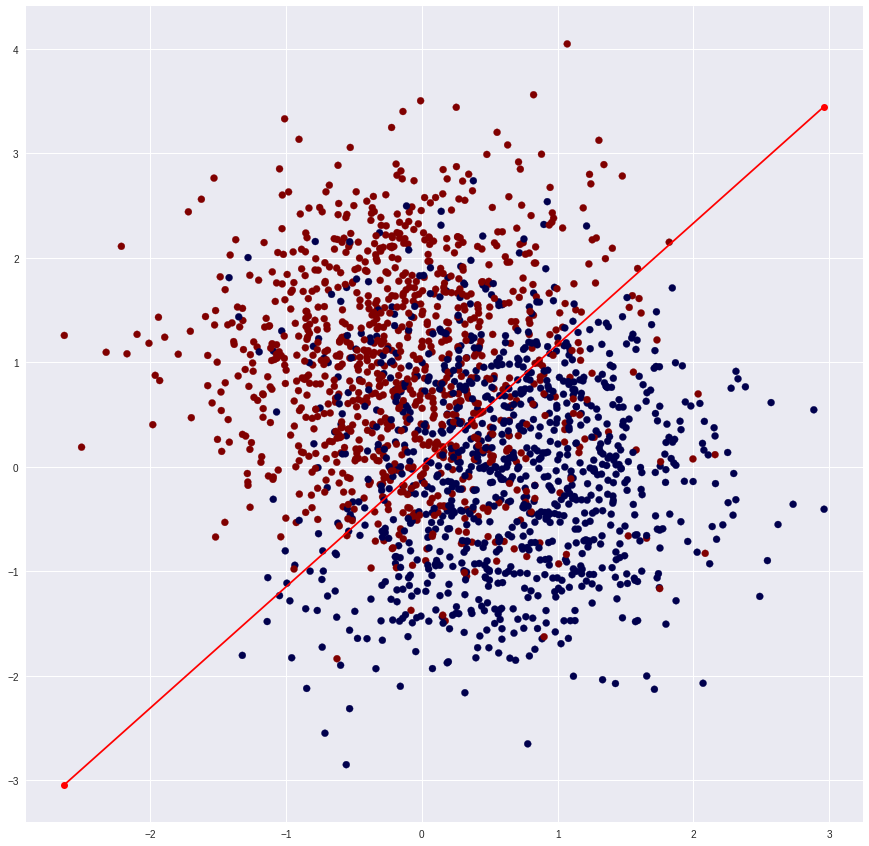

In [138]:
plot_graph(X, y, weights)

### Results

Our implementation after 5 iterations has an error rate of 0.216